Epoch 1/50


D:\ANACONDA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 106.1546 - mae: 4.5637 - val_loss: 10.7595 - val_mae: 1.7855
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7520 - mae: 1.7843 - val_loss: 10.6715 - val_mae: 1.7765
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.8145 - mae: 1.7881 - val_loss: 10.8210 - val_mae: 1.7855
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.7875 - mae: 1.7864 - val_loss: 10.6684 - val_mae: 1.7753
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7384 - mae: 1.7793 - val_loss: 10.6539 - val_mae: 1.7727
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7748 - mae: 1.7808 - val_loss: 10.7151 - val_mae: 1.7799
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7353 - mae: 1.7774 - val_loss: 10.6779 - val_mae: 1.7767
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7276 - mae: 1.7761 - val_loss: 11.1396 - val_mae: 1.8127
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━

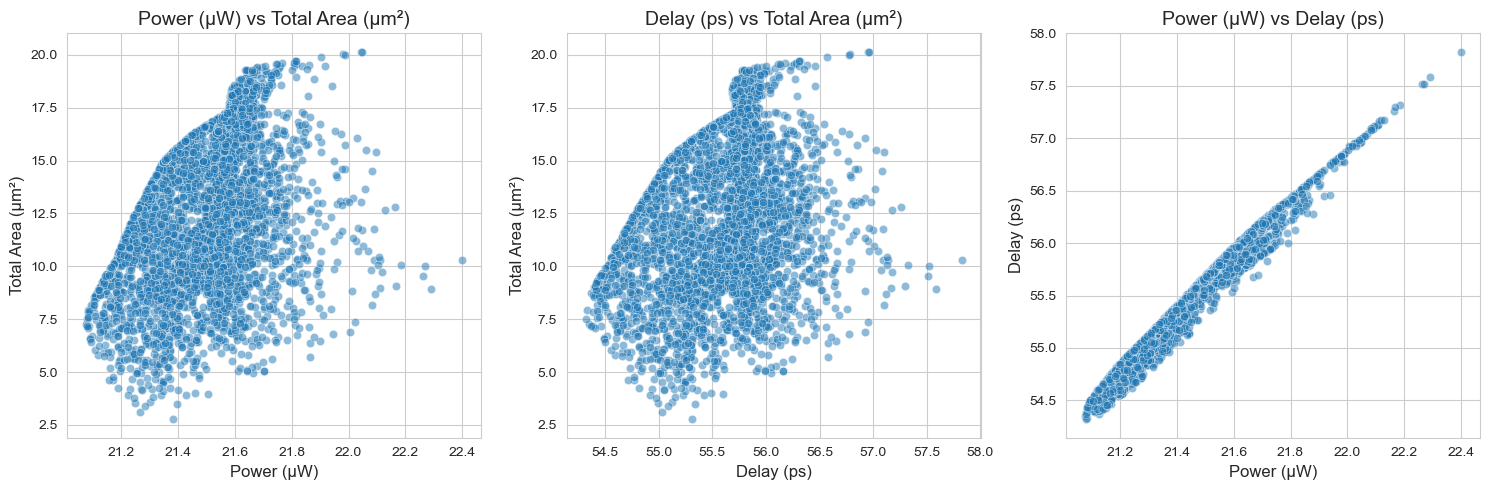

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

# Step 1: Load CSV with Encoding Detection
file_path = r"C:\Users\vivek\Downloads\ltspice_datanands.csv"  # Update if needed

with open(file_path, "rb") as f:
    rawdata = f.read(10000)
    result = chardet.detect(rawdata)
encoding_type = result['encoding']

try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 2: Add Total Widths (Keep Individual Widths Too)
data['NMOS_Total_Width'] = data['NMOS1_W'] + data['NMOS2_W']
data['PMOS_Total_Width'] = data['PMOS1_W'] + data['PMOS2_W']

# Step 3: Define Features and Target Labels
feature_columns = ['NMOS_Total_Width', 'PMOS_Total_Width', 'VDD']  # Inputs to model
target_columns = [
    'Power (µW)', 'Delay (ps)', 'Total Area (µm²)', 'Rise Time (ps)', 'Fall Time (ps)',
    'Energy (fJ)', 'Leakage Power (nW)', 'Output Swing (V)', 'Noise Margin High (V)',
    'Noise Margin Low (V)', 'Threshold Voltage (V)', 'Load Capacitance (fF)', 'Gate Overdrive (V)'
]

X = data[feature_columns].values
y = data[target_columns].values

# Step 4: Normalize Inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Step 6: Define the Neural Network
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(target_columns))  # Output for all targets
])

# Step 7: Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Step 9: Predict & Evaluate
y_pred = model.predict(X_test)
mae_scores = {target_columns[i]: mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_columns))}

# Step 10: Display Performance
print("\n📊 Random Forest Regression Model Performance (PPA Prediction for NAND Gate)")
for target, mae in mae_scores.items():
    print(f"{target} - Mean Absolute Error (MAE): {mae:.4f}")

# Step 11: Save Predictions with All 4 Transistor Widths + VDD
original_inputs = data.loc[index_test, ['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W', 'VDD']].reset_index(drop=True)
predictions_df = pd.DataFrame(y_pred, columns=target_columns)
final_output = pd.concat([original_inputs, predictions_df], axis=1)
final_output.insert(0, 'Index', np.arange(len(final_output)))

output_file = r"C:\Users\vivek\Downloads\nand_gate_predictions_4transistor.csv"
final_output.to_csv(output_file, index=False)
print(f"\n✅ Predicted values (with all 4 transistor widths + VDD) saved to: {output_file}")

# Step 12: Plot PPA Relationships
sns.set_style("whitegrid")
plot_pairs = [("Power (µW)", "Total Area (µm²)"), ("Delay (ps)", "Total Area (µm²)"), ("Power (µW)", "Delay (ps)")]

plt.figure(figsize=(15, 5))
for i, (x_col, y_col) in enumerate(plot_pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=predictions_df[x_col], y=predictions_df[y_col], alpha=0.5)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.title(f"{x_col} vs {y_col}", fontsize=14)

plt.tight_layout()
plt.show()



📊 NAND Gate Model Performance (Random Forest)
Power (µW) - Mean Absolute Error (MAE): 2.8862
Delay (ps) - Mean Absolute Error (MAE): 4.2735
Total Area (µm²) - Mean Absolute Error (MAE): 1.1927

✅ Output sheet saved at: C:\Users\vivek\Downloads\NAND_RF_predictions.csv


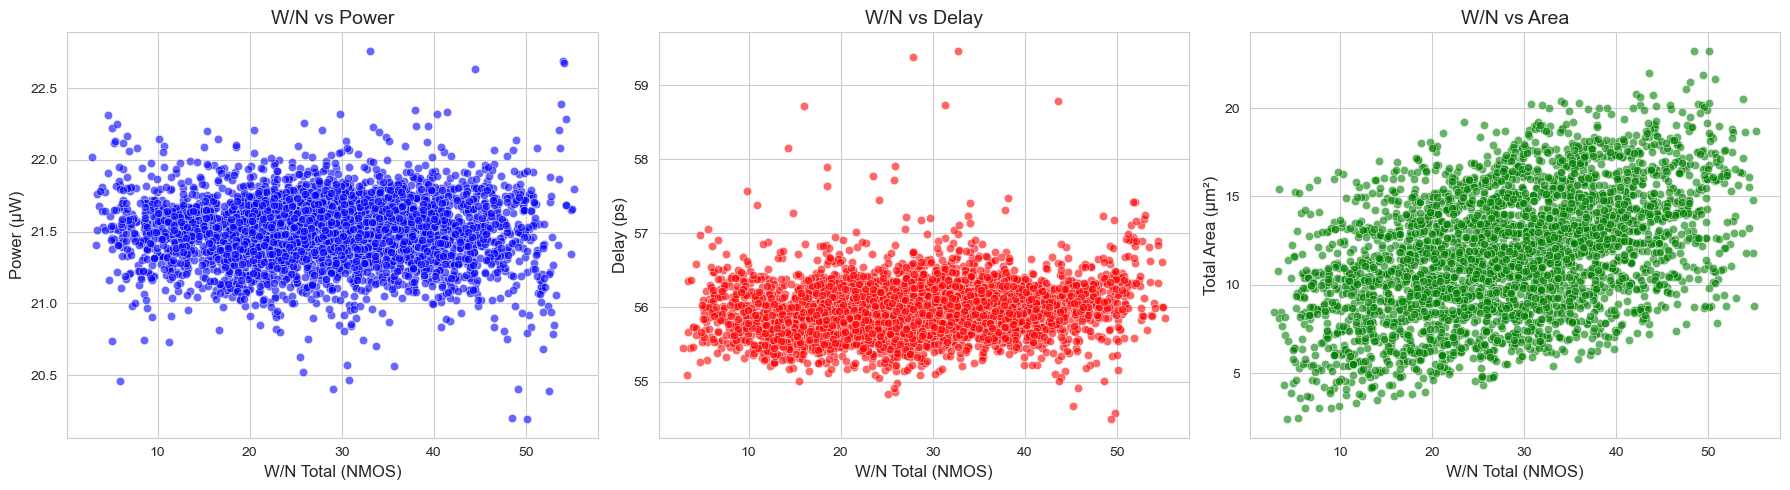

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime

# Step 1: Detect File Encoding
file_path = r"C:\Users\vivek\Downloads\ltspice_datanands.csv"
with open(file_path, "rb") as f:
    result = chardet.detect(f.read())
encoding_type = result['encoding']

# Step 2: Load LTspice Data
try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 3: Compute Total Widths
data['NMOS_Total_Width'] = data['NMOS1_W'] + data['NMOS2_W']
data['PMOS_Total_Width'] = data['PMOS1_W'] + data['PMOS2_W']

# Step 4: Define Features and Targets
feature_columns = ['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W',
                   'NMOS_Total_Width', 'PMOS_Total_Width', 'VDD']

target_columns = ['Power (µW)', 'Delay (ps)', 'Total Area (µm²)']

X = data[feature_columns]
y = data[target_columns]

# Step 5: Calculate Width/Length Ratio for NMOS (L = 0.18 µm)
L = 0.18
data['W/N_NMOS1'] = data['NMOS1_W'] / L
data['W/N_NMOS2'] = data['NMOS2_W'] / L
data['W/N_Total'] = data['NMOS_Total_Width'] / L

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Train Random Forest Regressors
models = {}
for target in target_columns:
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

# Step 8: Predict and Evaluate
predictions = {}
mae_scores = {}
for target in target_columns:
    y_pred = models[target].predict(X_test)
    predictions[target] = y_pred
    mae_scores[target] = mean_absolute_error(y_test[target], y_pred)

# Step 9: Display Model Performance
print("\n📊 NAND Gate Model Performance (Random Forest)")
for target, mae in mae_scores.items():
    print(f"{target} - Mean Absolute Error (MAE): {mae:.4f}")

# Step 10: Prepare Prediction DataFrame
df_pred = pd.DataFrame(predictions, columns=target_columns)
df_pred['W/N_Total'] = (X_test['NMOS1_W'].values + X_test['NMOS2_W'].values) / L

# Step 11: Add Transistor Widths to Output
df_pred['NMOS1_W'] = X_test['NMOS1_W'].values
df_pred['NMOS2_W'] = X_test['NMOS2_W'].values
df_pred['PMOS1_W'] = X_test['PMOS1_W'].values
df_pred['PMOS2_W'] = X_test['PMOS2_W'].values
df_pred['VDD'] = X_test['VDD'].values

# Step 12: Save Output to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = fr"C:\Users\vivek\Downloads\NAND_RF_predictions.csv"
df_pred.to_csv(output_path, index=False)
print(f"\n✅ Output sheet saved at: {output_path}")

# Step 13: Plot Results
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# W/N vs Power
sns.scatterplot(x=df_pred['W/N_Total'], y=df_pred['Power (µW)'], ax=axes[0], color="blue", alpha=0.6)
axes[0].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[0].set_ylabel("Power (µW)", fontsize=12)
axes[0].set_title("W/N vs Power", fontsize=14)

# W/N vs Delay
sns.scatterplot(x=df_pred['W/N_Total'], y=df_pred['Delay (ps)'], ax=axes[1], color="red", alpha=0.6)
axes[1].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[1].set_ylabel("Delay (ps)", fontsize=12)
axes[1].set_title("W/N vs Delay", fontsize=14)

# W/N vs Area
sns.scatterplot(x=df_pred['W/N_Total'], y=df_pred['Total Area (µm²)'], ax=axes[2], color="green", alpha=0.6)
axes[2].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[2].set_ylabel("Total Area (µm²)", fontsize=12)
axes[2].set_title("W/N vs Area", fontsize=14)

plt.tight_layout()
plt.show()


Epoch 1/50


D:\ANACONDA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 397.9968 - mae: 11.3775 - val_loss: 16.1340 - val_mae: 2.7800
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.1877 - mae: 2.6251 - val_loss: 12.3957 - val_mae: 2.4616
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.0775 - mae: 2.4288 - val_loss: 12.1761 - val_mae: 2.4494
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.7975 - mae: 2.3986 - val_loss: 11.8791 - val_mae: 2.4155
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.6216 - mae: 2.3789 - val_loss: 12.3024 - val_mae: 2.4468
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11.9426 - mae: 2.4120 - val_loss: 12.4412 - val_mae: 2.4481
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.8278 - mae: 2.3983 - val_loss: 12.0309 - val_mae: 2.4257
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.7654 - mae: 2.3919 - val_loss: 11.8848 - val_mae: 2.4124
Epoch 9/50
1000/1000 ━━━━━━━━━━━━

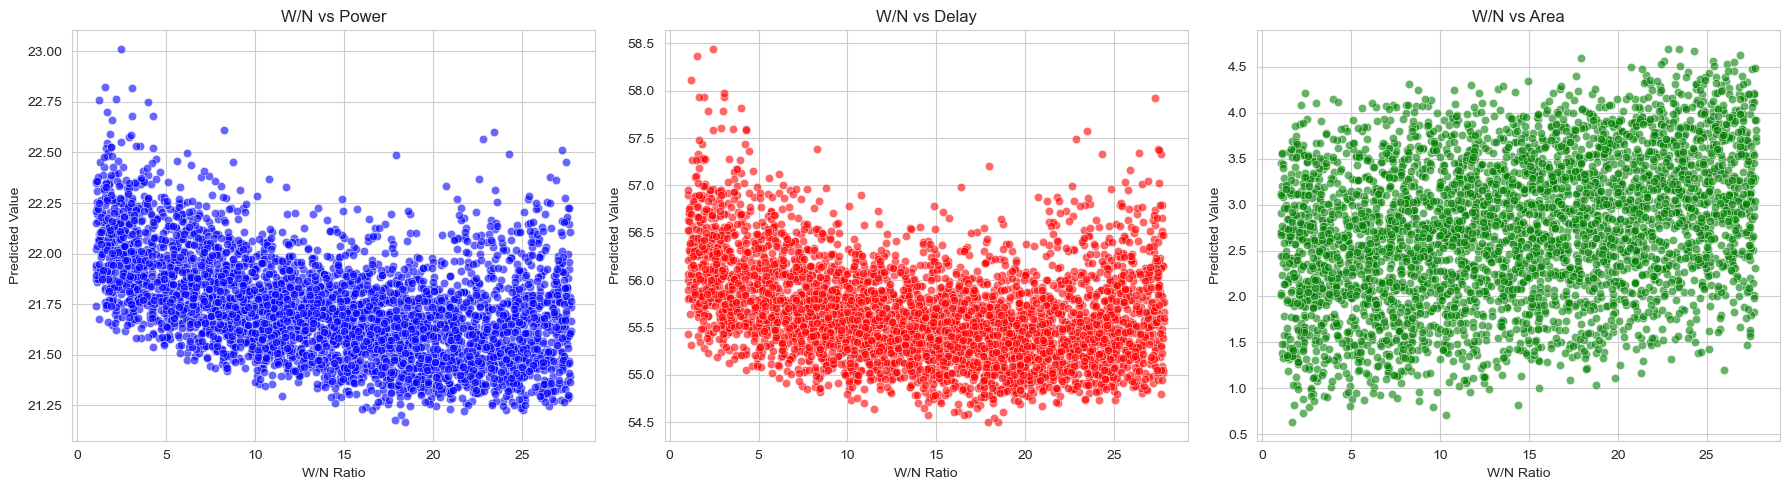

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from datetime import datetime

# Step 1: Detect File Encoding
file_path = r"C:\Users\vivek\Downloads\ltspice_datanands.csv"
with open(file_path, "rb") as f:
    result = chardet.detect(f.read())
encoding_type = result['encoding']

# Step 2: Load Data
try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 3: Define Inputs and Outputs
feature_columns = ['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W', 'VDD']
target_columns = ['Power (µW)', 'Delay (ps)', 'Area (µm²)']

# Additional columns to attach after prediction
additional_outputs = [
    'Rise Time (ps)', 'Fall Time (ps)', 'Energy (fJ)', 'Leakage Power (nW)',
    'Output Swing (V)', 'Noise Margin High (V)', 'Noise Margin Low (V)',
    'Threshold Voltage (V)', 'Load Capacitance (fF)', 'Gate Overdrive (V)'
]

X = data[feature_columns].values
y = data[target_columns].values

# Step 4: Calculate W/N ratio for each NMOS (L = 0.18 µm)
L = 0.18
data['W/N_NMOS1'] = data['NMOS1_W'] / L
data['W/N_NMOS2'] = data['NMOS2_W'] / L
data['W/N_Total'] = (data['NMOS1_W'] + data['NMOS2_W']) / L

# Step 5: Normalize Inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Split Dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42)

# Step 7: Build Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(len(target_columns))
])

# Step 8: Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Step 9: Predictions
y_pred = model.predict(X_test)

# Step 10: MAE for Predicted Parameters
mae_scores = {target_columns[i]: mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_columns))}
print("\n📊 Mean Absolute Error (Predicted Parameters):")
for param, mae in mae_scores.items():
    print(f"{param}: {mae:.4f}")

# Step 11: Retrieve Original Widths from Unscaled Data
nmos1_w = data.loc[idx_test, 'NMOS1_W'].values
nmos2_w = data.loc[idx_test, 'NMOS2_W'].values
pmos1_w = data.loc[idx_test, 'PMOS1_W'].values
pmos2_w = data.loc[idx_test, 'PMOS2_W'].values

# Step 12: Build Final Output DataFrame
predicted_df = pd.DataFrame({
    'NMOS1_W': nmos1_w,
    'NMOS2_W': nmos2_w,
    'PMOS1_W': pmos1_w,
    'PMOS2_W': pmos2_w,
    'Power': y_pred[:, 0],
    'Delay': y_pred[:, 1],
    'Area': y_pred[:, 2]
})

# Step 13: Add actual additional parameter columns
additional_df = data.loc[idx_test, additional_outputs].reset_index(drop=True)
final_df = pd.concat([predicted_df, additional_df], axis=1)

# Step 14: Sanity Check
if (predicted_df[['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W']] < 0).any().any():
    print("❗ Warning: Negative widths detected in predictions!")

# Step 15: Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = fr"C:\Users\vivek\Downloads\NAND_neural_network_prediction.csv"
final_df.to_csv(output_file, index=False)
print(f"\n✅ Results saved to: {output_file}")

# Step 16: Plot W/N Ratio vs Predicted PPA
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recompute W/N ratio for plotting
W_N_ratio = predicted_df['NMOS1_W'] / L

sns.scatterplot(x=W_N_ratio, y=predicted_df['Power'], ax=axes[0], color="blue", alpha=0.6)
axes[0].set_title("W/N vs Power")

sns.scatterplot(x=W_N_ratio, y=predicted_df['Delay'], ax=axes[1], color="red", alpha=0.6)
axes[1].set_title("W/N vs Delay")

sns.scatterplot(x=W_N_ratio, y=predicted_df['Area'], ax=axes[2], color="green", alpha=0.6)
axes[2].set_title("W/N vs Area")

for ax in axes:
    ax.set_xlabel("W/N Ratio")
    ax.set_ylabel("Predicted Value")

plt.tight_layout()
plt.show()


In [4]:
# 📊 NN + GA Circuit Optimizer (Refactored & Modular)

import pandas as pd
import numpy as np
import os
import random
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from joblib import dump, load
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns

# ======================= CONFIG =========================
DATA_PATH = r"C:\Users\vivek\Downloads\NAND_neural_network_prediction.csv"
data = pd.read_csv(DATA_PATH)
MODEL_PATH = "knn_model.pkl"
POP_SIZE = 40
NGEN = 30
NMOS_FIXED = (1.0, 1.0)
PMOS_SWEEP = np.linspace(0.5, 2.0, 50)
MIN_WIDTH = 0.05
MAX_WIDTH = 2.0

priorities = ['all', 'area_power', 'delay_power', 'delay_area', 'power', 'delay', 'area']
results, outputs, pareto_data = {}, {}, {}
comparison_df = []

# ====================== LOAD DATA =======================
data = pd.read_csv(DATA_PATH)
X = data[['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W']].values
Y = data[['Power', 'Delay', 'Area']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# ===================== KNN MODEL ========================
if os.path.exists(MODEL_PATH):
    model = load(MODEL_PATH)
else:
    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(X_train, Y_train)
    dump(model, MODEL_PATH)

# ===================== DEAP SETUP =======================
if "FitnessMulti" not in creator.__dict__:
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.5, 2.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Clamp decorator
def check_bounds(min_val, max_val):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for ind in offspring:
                for i in range(len(ind)):
                    ind[i] = min(max(ind[i], min_val), max_val)
            return offspring
        return wrapper
    return decorator

toolbox.decorate("mate", check_bounds(MIN_WIDTH, MAX_WIDTH))
toolbox.decorate("mutate", check_bounds(MIN_WIDTH, MAX_WIDTH))

# ==================== EVALUATOR ========================
def get_evaluator(priority):
    def evaluate(ind):
        scaled = scaler.transform([ind])
        power, delay, area = model.predict(scaled)[0]
        if priority == 'area_power': return power, 0, area
        if priority == 'delay_power': return power, delay, 0
        if priority == 'delay_area': return 0, delay, area
        if priority == 'power': return power, 0, 0
        if priority == 'delay': return 0, delay, 0
        if priority == 'area': return 0, 0, area
        return power, delay, area
    return evaluate

# =================== GA EXECUTION ======================
def run_ga(priority):
    try: toolbox.unregister("evaluate")
    except: pass
    toolbox.register("evaluate", get_evaluator(priority))

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.ParetoFront()
    for _ in range(NGEN):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.2)
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)
        pop = toolbox.select(pop + offspring, k=POP_SIZE)
        hof.update(pop)

    best = tools.selBest(pop, k=1)[0]
    power, delay, area = model.predict(scaler.transform([best]))[0]
    outputs[priority] = (*best, power, delay, area)
    pareto_data[priority] = [(ind[0], ind[1], ind[2], ind[3], *model.predict(scaler.transform([ind]))[0]) for ind in pop]
    comparison_df.append({'Priority': priority.upper(), 'Power': power, 'Delay': delay, 'Area': area})
    print(f"→ {priority.upper()}: W1={best[0]:.3f}, W2={best[1]:.3f}, P1={best[2]:.3f}, P2={best[3]:.3f} → Power={power:.2f}, Delay={delay:.2f}, Area={area:.2f}")

# ===================== PLOTS ==========================
def plot_pareto():
    for priority in priorities:
        data = np.array([[p[4], p[5], p[6]] for p in pareto_data[priority]])
        plt.figure(figsize=(8, 6))
        plt.scatter(data[:, 1], data[:, 0], c=data[:, 2], cmap='viridis', s=60)
        plt.colorbar(label='Area (µm²)')
        plt.xlabel("Delay (ps)")
        plt.ylabel("Power (µW)")
        plt.title(f"Pareto Front - {priority.upper()}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"pareto_{priority}.png")
        plt.close()

def plot_radar():
    labels = ['Power', 'Delay', 'Area']
    angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
    angles += angles[:1]
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    for priority in priorities:
        values = list(outputs[priority][4:]) + [outputs[priority][4]]
        ax.plot(angles, values, label=priority.upper())
        ax.fill(angles, values, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title("Radar Plot - Power, Delay, Area")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.savefig("radar_plot.png")
    plt.close()

def plot_pmos_sweep():
    p1, p2 = PMOS_SWEEP, PMOS_SWEEP
    pw, dw, aw = [], [], []
    for val in p1:
        out = model.predict(scaler.transform([[*NMOS_FIXED, val, val]]))[0]
        pw.append(out[0])
        dw.append(out[1])
        aw.append(out[2])
    plt.figure(figsize=(10, 6))
    plt.plot(p1, pw, label='Power')
    plt.plot(p1, dw, label='Delay')
    plt.plot(p1, aw, label='Area')
    plt.xlabel("PMOS Width")
    plt.ylabel("Metric Value")
    plt.title("Metrics vs PMOS Width (Fixed NMOS1 = 1.0, NMOS2 = 1.0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pmos_sweep.png")
    plt.close()

def plot_comparison():
    df = pd.DataFrame(comparison_df)
    sns.pairplot(df, hue="Priority", diag_kind='kde', palette='husl')
    plt.suptitle("Multi-objective Comparison Across Priorities", y=1.02)
    plt.tight_layout()
    plt.savefig("priority_comparison.png")
    plt.close()

# =================== RUN ALL ===========================
for p in priorities:
    print(f"\nRunning GA for Priority: {p.upper()}")
    run_ga(p)

plot_pareto()
plot_radar()
plot_pmos_sweep()
plot_comparison()

print("\nAll plots saved. Optimization complete.")



Running GA for Priority: ALL
→ ALL: W1=1.603, W2=1.895, P1=1.073, P2=1.716 → Power=21.58, Delay=56.10, Area=1.19

Running GA for Priority: AREA_POWER
→ AREA_POWER: W1=1.071, W2=0.614, P1=1.859, P2=1.213 → Power=21.56, Delay=55.98, Area=0.86

Running GA for Priority: DELAY_POWER
→ DELAY_POWER: W1=0.520, W2=1.048, P1=1.820, P2=1.731 → Power=21.59, Delay=55.93, Area=0.82

Running GA for Priority: DELAY_AREA
→ DELAY_AREA: W1=0.643, W2=0.846, P1=1.323, P2=1.665 → Power=21.61, Delay=56.00, Area=0.75

Running GA for Priority: POWER
→ POWER: W1=1.958, W2=1.536, P1=0.603, P2=1.925 → Power=21.54, Delay=56.15, Area=1.09

Running GA for Priority: DELAY
→ DELAY: W1=0.829, W2=0.910, P1=1.200, P2=1.440 → Power=21.58, Delay=55.98, Area=0.76

Running GA for Priority: AREA
→ AREA: W1=1.516, W2=1.174, P1=1.330, P2=1.083 → Power=21.55, Delay=56.00, Area=0.92

All plots saved. Optimization complete.



Running GA for Priority: ALL
→ Optimized Widths: NMOS1 = 1.357, NMOS2 = 1.637, PMOS1 = 1.542, PMOS2 = 1.912
  Predicted: Power = 21.64 µW, Delay = 55.48 ps, Area = 1.16 µm²

Running GA for Priority: AREA_POWER
→ Optimized Widths: NMOS1 = 1.147, NMOS2 = 1.239, PMOS1 = 1.175, PMOS2 = 1.085
  Predicted: Power = 21.80 µW, Delay = 55.89 ps, Area = 0.91 µm²

Running GA for Priority: DELAY_POWER
→ Optimized Widths: NMOS1 = 0.725, NMOS2 = 1.847, PMOS1 = 1.959, PMOS2 = 1.235
  Predicted: Power = 21.89 µW, Delay = 56.10 ps, Area = 1.02 µm²

Running GA for Priority: DELAY_AREA
→ Optimized Widths: NMOS1 = 1.753, NMOS2 = 1.826, PMOS1 = 1.536, PMOS2 = 1.427
  Predicted: Power = 21.62 µW, Delay = 55.49 ps, Area = 1.09 µm²

Running GA for Priority: POWER
→ Optimized Widths: NMOS1 = 1.276, NMOS2 = 0.630, PMOS1 = 1.830, PMOS2 = 0.524
  Predicted: Power = 21.72 µW, Delay = 55.78 ps, Area = 0.88 µm²

Running GA for Priority: DELAY
→ Optimized Widths: NMOS1 = 0.621, NMOS2 = 0.893, PMOS1 = 1.273, PMOS2 = 1

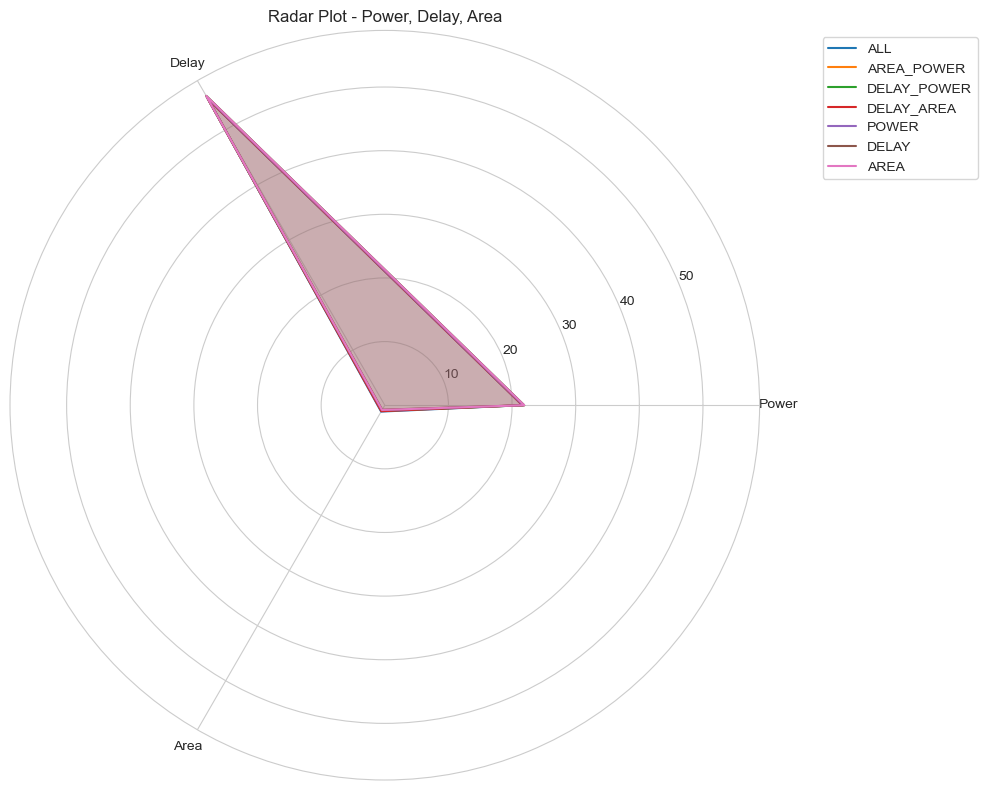

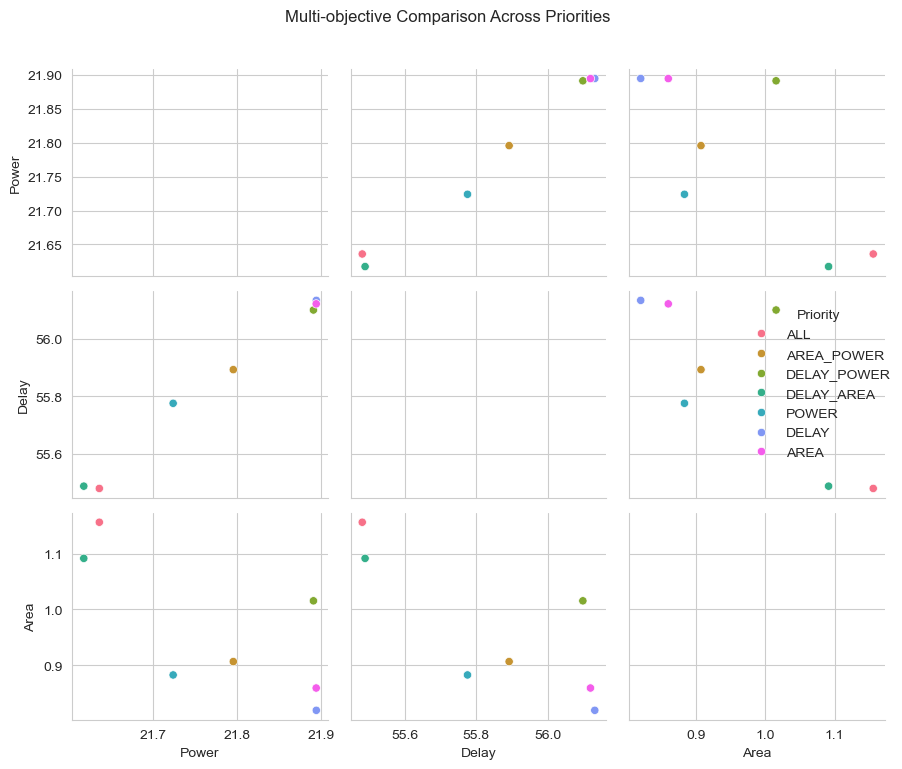

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

# Load dataset for 2-NMOS, 2-PMOS NAND gate
data = pd.read_csv(r"C:\Users\vivek\Downloads\NAND_neural_network_prediction.csv")
X = data[['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W']].values
Y = data[['Power', 'Delay', 'Area']].values

# Normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train KNN model
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, Y_train)

# GA setup with DEAP
if "FitnessMulti" not in creator.__dict__:
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.5, 2.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Clamp bounds
def check_bounds(min_val, max_val):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for ind in offspring:
                for i in range(len(ind)):
                    ind[i] = max(min_val, min(ind[i], max_val))
            return offspring
        return wrapper
    return decorator

MIN_WIDTH = 0.05
MAX_WIDTH = 2.0
toolbox.decorate("mate", check_bounds(MIN_WIDTH, MAX_WIDTH))
toolbox.decorate("mutate", check_bounds(MIN_WIDTH, MAX_WIDTH))

# Evaluation function
def get_evaluator(priority):
    def evaluate(ind):
        input_scaled = scaler.transform([ind])
        power, delay, area = model.predict(input_scaled)[0]
        if priority == 'all': return power, delay, area
        if priority == 'area_power': return power, 0, area
        if priority == 'delay_power': return power, delay, 0
        if priority == 'delay_area': return 0, delay, area
        if priority == 'power': return power, 0, 0
        if priority == 'delay': return 0, delay, 0
        if priority == 'area': return 0, 0, area
        return power, delay, area
    return evaluate

# Run GA for each priority
priorities = ['all', 'area_power', 'delay_power', 'delay_area', 'power', 'delay', 'area']
results, outputs, pareto_data, comparison_df = {}, {}, {}, []

for priority in priorities:
    print(f"\nRunning GA for Priority: {priority.upper()}")
    try: toolbox.unregister("evaluate")
    except: pass
    toolbox.register("evaluate", get_evaluator(priority))

    pop = toolbox.population(n=40)
    hof = tools.ParetoFront()
    
    for gen in range(30):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.2)
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)
        pop = toolbox.select(pop + offspring, k=40)
        hof.update(pop)

    best = tools.selBest(pop, k=1)[0]
    results[priority] = best
    power, delay, area = model.predict(scaler.transform([best]))[0]
    outputs[priority] = (*best, power, delay, area)
    pareto_data[priority] = [(ind[0], ind[1], ind[2], ind[3], *model.predict(scaler.transform([ind]))[0]) for ind in pop]

    comparison_df.append({'Priority': priority.upper(), 'Power': power, 'Delay': delay, 'Area': area})
    print(f"→ Optimized Widths: NMOS1 = {best[0]:.3f}, NMOS2 = {best[1]:.3f}, PMOS1 = {best[2]:.3f}, PMOS2 = {best[3]:.3f}")
    print(f"  Predicted: Power = {power:.2f} µW, Delay = {delay:.2f} ps, Area = {area:.2f} µm²")

print("\nFinal Optimized Results:")
for priority in priorities:
    n1, n2, p1, p2, power, delay, area = outputs[priority]
    print(f"{priority.upper()}: NMOS1 = {n1:.3f}, NMOS2 = {n2:.3f}, PMOS1 = {p1:.3f}, PMOS2 = {p2:.3f} → Power = {power:.2f} µW, Delay = {delay:.2f} ps, Area = {area:.2f} µm²")

# Radar Plot
labels = ['Power', 'Delay', 'Area']
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))] + [0]
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

for priority in priorities:
    values = list(outputs[priority][4:]) + [outputs[priority][4]]
    ax.plot(angles, values, label=priority.upper())
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Radar Plot - Power, Delay, Area")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

# Comparison Plot
comparison_df = pd.DataFrame(comparison_df)
sns.pairplot(comparison_df, hue="Priority", diag_kind='kde', palette='husl')
plt.suptitle("Multi-objective Comparison Across Priorities", y=1.02)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# === Load Dataset ===
data = pd.read_csv(r"C:\Users\vivek\Downloads\NAND_neural_network_prediction.csv")

# === Extract Features and Targets ===
X = data[['NMOS1_W', 'NMOS2_W', 'PMOS1_W', 'PMOS2_W']].values
Y = data[['Power', 'Delay', 'Area']].values

# === Normalize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train KNN Regressor ===
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_scaled, Y)

# === User Input Prediction Section ===
MIN_WIDTH = 0.05
MAX_WIDTH = 2.0

print("\nEnter transistor widths to predict Power, Delay, and Area:")
try:
    nmos1 = float(input("Enter NMOS1 Width (0.05 to 2.0): "))
    nmos2 = float(input("Enter NMOS2 Width (0.05 to 2.0): "))
    pmos1 = float(input("Enter PMOS1 Width (0.05 to 2.0): "))
    pmos2 = float(input("Enter PMOS2 Width (0.05 to 2.0): "))

    widths = [nmos1, nmos2, pmos1, pmos2]
    
    # Check if widths are within the allowed range
    if any(w < MIN_WIDTH or w > MAX_WIDTH for w in widths):
        print("⚠️ Error: All widths must be between 0.05 and 2.0 µm.")
    else:
        input_scaled = scaler.transform([widths])
        predicted_power, predicted_delay, predicted_area = model.predict(input_scaled)[0]
        print("\n🔎 Predicted Results for Your Input:")
        print(f"→ Power = {predicted_power:.2f} µW")
        print(f"→ Delay = {predicted_delay:.2f} ps")
        print(f"→ Area  = {predicted_area:.2f} µm²")

except ValueError:
    print("❌ Invalid input. Please enter valid floating-point numbers.")



Enter transistor widths to predict Power, Delay, and Area:


Enter NMOS1 Width (0.05 to 2.0):  0.23
Enter NMOS2 Width (0.05 to 2.0):  0.54
Enter PMOS1 Width (0.05 to 2.0):  0.532
Enter PMOS2 Width (0.05 to 2.0):  0.432



🔎 Predicted Results for Your Input:
→ Power = 22.02 µW
→ Delay = 56.42 ps
→ Area  = 0.72 µm²
